In [1]:
# All coding credits to... https://www.kaggle.com/myonin/bitcoin-price-prediction-by-arima
# This Work only updates the Data and comments with details

In [2]:
# Import libraries
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy import stats
import statsmodels.api as sm
import warnings
from itertools import product
from datetime import datetime
warnings.filterwarnings('ignore')
plt.style.use('seaborn-poster')

In [3]:
# Load data
df = pd.read_csv('data/bitcoin-historical-data/coinbaseUSD_1-min_data_2014-12-01_to_2018-06-27.csv')
print(df.head(10).to_string())# viewing just first views items

    Timestamp   Open   High    Low  Close  Volume_(BTC)  Volume_(Currency)  Weighted_Price
0  1417411980  300.0  300.0  300.0  300.0          0.01                3.0           300.0
1  1417412040  300.0  300.0  300.0  300.0          0.01                3.0           300.0
2  1417412100  300.0  300.0  300.0  300.0          0.01                3.0           300.0
3  1417412160  300.0  300.0  300.0  300.0          0.01                3.0           300.0
4  1417412220  300.0  300.0  300.0  300.0          0.01                3.0           300.0
5  1417412280  300.0  300.0  300.0  300.0          0.01                3.0           300.0
6  1417412340  300.0  300.0  300.0  300.0          0.01                3.0           300.0
7  1417412400  300.0  300.0  300.0  300.0          0.01                3.0           300.0
8  1417412460  300.0  300.0  300.0  300.0          0.01                3.0           300.0
9  1417412520  300.0  300.0  300.0  300.0          0.01                3.0           300.0

In [4]:
# Unix-time to
df.Timestamp = pd.to_datetime(df.Timestamp, unit='s')

# Resampling to daily frequency
df.index = df.Timestamp
df = df.resample('D').mean() # resample by day and give means 왜나면 원래 데이터가 1분씩 갱싱되던 데이터였으니


# Resampling to monthly frequency
df_month = df.resample('M').mean()
# Resampling to annual frequency
df_year = df.resample('A-DEC').mean()

# Resampling to quarterly frequency
df_Q = df.resample('Q-DEC').mean()


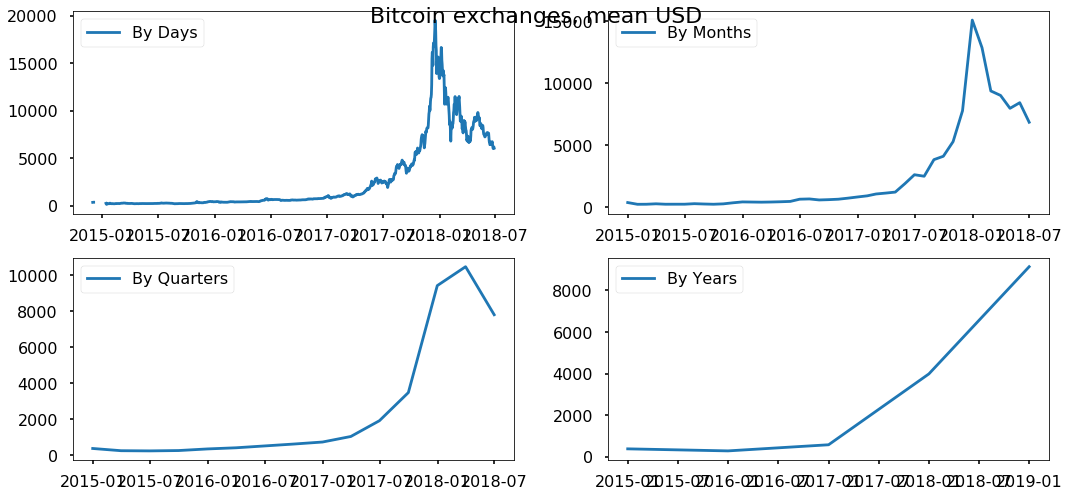

In [5]:
# PLOTS
fig = plt.figure(figsize=[15, 7])
plt.suptitle('Bitcoin exchanges, mean USD', fontsize=22)

plt.subplot(221)
plt.plot(df.Weighted_Price, '-', label='By Days')
plt.legend()

plt.subplot(222)
plt.plot(df_month.Weighted_Price, '-', label='By Months')
plt.legend()

plt.subplot(223)
plt.plot(df_Q.Weighted_Price, '-', label='By Quarters')
plt.legend()

plt.subplot(224)
plt.plot(df_year.Weighted_Price, '-', label='By Years')
plt.legend()

plt.tight_layout()
plt.show()

Dickey–Fuller test: p=(0.7851425786483504, 0.9913925164230809, 10, 32, {'1%': -3.653519805908203, '5%': -2.9572185644531253, '10%': -2.6175881640625}, 535.7081695338891)


<Figure size 1080x504 with 0 Axes>

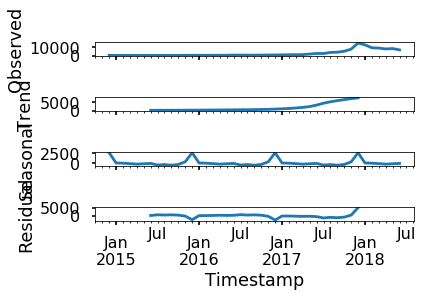

In [6]:
# Dickey-Fuller 단위근 검정(unit root test)은 ARIMA 모형의 적분 차수를 판단하기 위한 검정 방법의 하나이다.
# 이 그래프로 보면서 아 이거 arima가능하겟네 라고 판단함 dickey-fuller test로
# results shows that this is non-stationary
plt.figure(figsize=[15, 7])
sm.tsa.seasonal_decompose(df_month.Weighted_Price).plot()
print(f'Dickey–Fuller test: p={sm.tsa.stattools.adfuller(df_month.Weighted_Price)}')

In [7]:
# 비정상 확률 과정을 정상 확률 과정으로 변환하기
# Box-Cox Transformations
df_month['Weighted_Price_box'], lmbda = stats.boxcox(df_month.Weighted_Price)
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.Weighted_Price)[1])

Dickey–Fuller test: p=0.991393


In [8]:
# Seasonal differentiation (12개월차이값)
df_month['prices_box_diff'] = df_month.Weighted_Price_box - df_month.Weighted_Price_box.shift(12) #12months 데이터를 아래로 내렸다 그리고 원래 데이터에서 뺐다.
print("Dickey–Fuller test: p=%f" % sm.tsa.stattools.adfuller(df_month.prices_box_diff[12:])[1])

Dickey–Fuller test: p=0.313566


In [9]:
# Regular differentiation
df_month['prices_box_diff2'] = df_month.prices_box_diff - df_month.prices_box_diff.shift(1) # 일반적인 diff이지만 이미 diff한것의 diff이니깐 2차 diff
plt.figure(figsize=(15,7))

<Figure size 1080x504 with 0 Axes>

<Figure size 1080x504 with 0 Axes>

Dickey–Fuller test: (-5.502832177982467, 2.052916013827241e-06, 0, 29, {'1%': -3.6790595944893187, '5%': -2.9678817237279103, '10%': -2.6231583472057074}, -100.45230413096704)


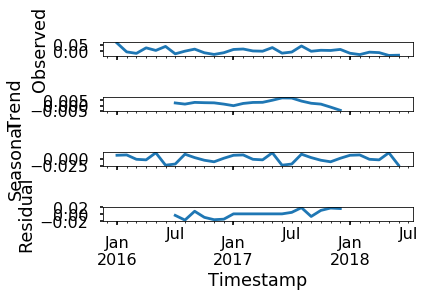

In [10]:
# p-value가 1%보다 작으니 null hypothesis (rho = 1, it's non-stationary) is rejected!
# STL-decomposition
sm.tsa.seasonal_decompose(df_month.prices_box_diff2[13:]).plot()
print(f"Dickey–Fuller test: {sm.tsa.stattools.adfuller(df_month.prices_box_diff2[13:])}")

In [11]:
# Initial approximation of parameters
Qs = range(0, 2)
qs = range(0, 3)
Ps = range(0, 3)
ps = range(0, 3)
D=1
d=1
parameters = product(ps, qs, Ps, Qs)
parameters_list = list(parameters)
len(parameters_list)

54

In [12]:
# Model Selection
results = []
best_aic = float("inf")
warnings.filterwarnings('ignore')
for param in parameters_list:
    try:
        # SARIMAX model as ARIMAX when seasonal_order is (0,0,0,0) but must check if this applies to here
        model = sm.tsa.statespace.SARIMAX(df_month.Weighted_Price_box, order=(param[0], d, param[1]),
                                        seasonal_order=(param[2], D, param[3], 12)).fit(disp=-1)
    except ValueError:
        print('wrong parameters:', param)
        continue
    aic = model.aic
    if aic < best_aic:
        best_model = model
        best_aic = aic
        best_param = param
    results.append([param, model.aic])

wrong parameters: (0, 0, 0, 1)
wrong parameters: (0, 0, 1, 1)
wrong parameters: (0, 0, 2, 1)
wrong parameters: (0, 1, 0, 1)
wrong parameters: (0, 1, 1, 1)
wrong parameters: (0, 1, 2, 1)
wrong parameters: (0, 2, 0, 1)
wrong parameters: (0, 2, 1, 1)
wrong parameters: (0, 2, 2, 1)
wrong parameters: (1, 0, 0, 1)
wrong parameters: (1, 0, 1, 1)
wrong parameters: (1, 0, 2, 1)
wrong parameters: (1, 1, 0, 0)
wrong parameters: (1, 1, 0, 1)
wrong parameters: (1, 1, 1, 0)
wrong parameters: (1, 1, 1, 1)
wrong parameters: (1, 1, 2, 0)
wrong parameters: (1, 1, 2, 1)
wrong parameters: (1, 2, 0, 1)
wrong parameters: (1, 2, 1, 1)
wrong parameters: (1, 2, 2, 1)
wrong parameters: (2, 0, 0, 1)
wrong parameters: (2, 0, 1, 1)
wrong parameters: (2, 0, 2, 1)
wrong parameters: (2, 1, 0, 0)
wrong parameters: (2, 1, 0, 1)
wrong parameters: (2, 1, 1, 0)
wrong parameters: (2, 1, 1, 1)
wrong parameters: (2, 1, 2, 0)
wrong parameters: (2, 1, 2, 1)
wrong parameters: (2, 2, 0, 0)
wrong parameters: (2, 2, 0, 1)
wrong pa

In [13]:
# Best Models
result_table = pd.DataFrame(results)
result_table.columns = ['parameters', 'aic']
print(result_table.sort_values(by='aic', ascending=True).head())
print(best_model.summary())

     parameters         aic
0  (0, 0, 0, 0) -143.096039
2  (0, 0, 2, 0) -141.625719
1  (0, 0, 1, 0) -141.402128
3  (0, 1, 0, 0) -141.291044
9  (1, 0, 0, 0) -141.231204
                                 Statespace Model Results                                 
Dep. Variable:                 Weighted_Price_box   No. Observations:                   43
Model:             SARIMAX(0, 1, 0)x(0, 1, 0, 12)   Log Likelihood                  72.548
Date:                            Mon, 05 Nov 2018   AIC                           -143.096
Time:                                    21:06:07   BIC                           -141.695
Sample:                                12-31-2014   HQIC                          -142.648
                                     - 06-30-2018                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
-------------------------

Dickey–Fuller test:: p=0.000002


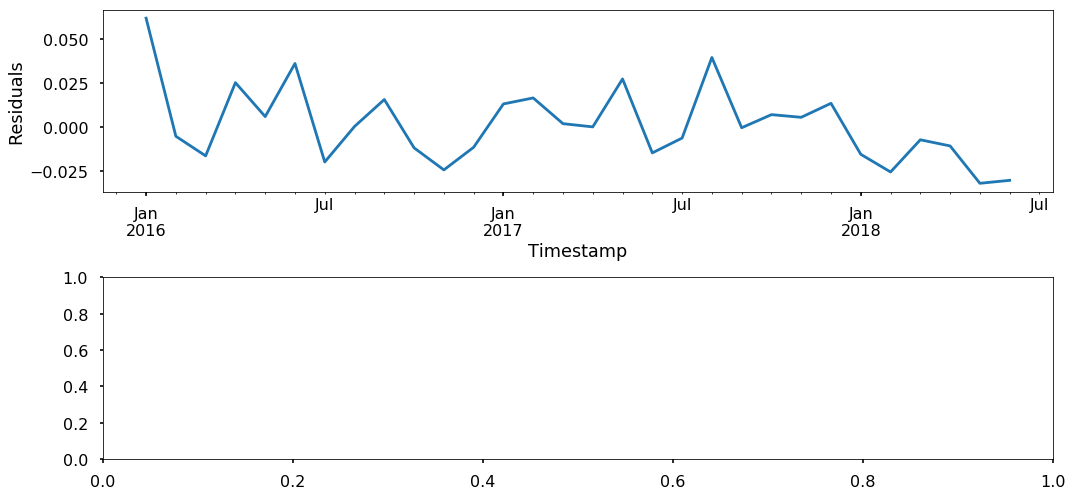

In [14]:
# STL-decomposition
plt.figure(figsize=(15, 7))
plt.subplot(211)
best_model.resid[13:].plot()
plt.ylabel(u'Residuals')
ax = plt.subplot(212)
# sm.graphics.tsa.plot_acf(best_model.resid[13:].values.squeeze(), lags=48, ax=ax)

print("Dickey–Fuller test:: p=%f" % sm.tsa.stattools.adfuller(best_model.resid[13:])[1])

plt.tight_layout()

           Close High  Low Open Volume_(BTC) Volume_(Currency)  \
2014-12-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-01-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-02-28   NaN  NaN  NaN  NaN          NaN               NaN   
2015-03-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-04-30   NaN  NaN  NaN  NaN          NaN               NaN   
2015-05-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-06-30   NaN  NaN  NaN  NaN          NaN               NaN   
2015-07-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-08-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-09-30   NaN  NaN  NaN  NaN          NaN               NaN   
2015-10-31   NaN  NaN  NaN  NaN          NaN               NaN   
2015-11-30   NaN  NaN  NaN  NaN          NaN               NaN   
2015-12-31   NaN  NaN  NaN  NaN          NaN               NaN   
2016-01-31   NaN  NaN  NaN  NaN          NaN               NaN   
2016-02-29

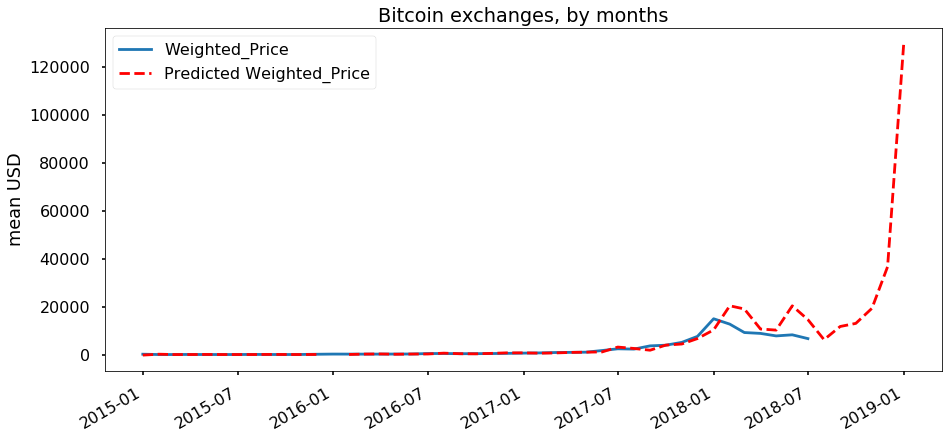

In [15]:
# Inverse Box-Cox Transformation Function
def invboxcox(y, lmbda):
   if lmbda == 0:
      return(np.exp(y))
   else:
      return(np.exp(np.log(lmbda*y+1)/lmbda))




# Prediction
df_month2 = df_month[['Weighted_Price']]
# date_list = [datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 9, 30), datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31), datetime(2019, 1, 31), datetime(2019, 2, 28), datetime(2019, 3, 31), datetime(2019, 4, 30), datetime(2019, 5, 31), datetime(2019, 6, 30), datetime(2019, 7, 31), datetime(2019, 8, 31), datetime(2019, 9, 30), datetime(2019, 9, 30), datetime(2019, 10, 31), datetime(2019, 11, 30)]
date_list = [datetime(2018, 7, 31), datetime(2018, 8, 31), datetime(2018, 9, 30), datetime(2018, 9, 30), datetime(2018, 10, 31), datetime(2018, 11, 30), datetime(2018, 12, 31),]

future = pd.DataFrame(index=date_list, columns=df_month.columns)
df_month2 = pd.concat([df_month2, future])
print(df_month2)
df_month2['forecast'] = invboxcox(best_model.predict(start=0, end=100), lmbda)
plt.figure(figsize=(15, 7))
df_month2.Weighted_Price.plot()
df_month2.forecast.plot(color='r', ls='--', label='Predicted Weighted_Price')
plt.legend()
plt.title('Bitcoin exchanges, by months')
plt.ylabel(u'mean USD')
plt.show()

Summary:
Assuming the Bicoin price has a seasonal factor, the price will sky-rocketed in the Dec of 2018.